# Notebook 2: Baseline Calibration Methods

## Purpose
This notebook implements and compares baseline calibration methods (non-Bayesian) to establish a baseline for comparison with Bayesian methods.

## Methods Implemented
1. **Uncalibrated** - Raw model predictions
2. **Temperature Scaling (L-BFGS)** - Single temperature parameter optimized with L-BFGS
3. **Platt Scaling** - Logistic regression on logits
4. **Isotonic Regression** - Non-parametric calibration

## Output
- Baseline calibration results
- Comparison table
- Saved calibrated temperatures and metrics


In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import os

np.random.seed(42)
torch.manual_seed(42)

print('Loading preprocessed data...')
logits_val = np.load('./data/processed/logits_val.npy')
labels_val = np.load('./data/processed/labels_val.npy')
logits_test = np.load('./data/processed/logits_test.npy')
labels_test = np.load('./data/processed/labels_test.npy')

print(f'✓ Data loaded')
print(f'  Validation: {logits_val.shape[0]} samples')
print(f'  Test: {logits_test.shape[0]} samples')


Loading preprocessed data...
✓ Data loaded
  Validation: 5000 samples
  Test: 5000 samples


In [11]:
def compute_ece(probs, labels, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    max_probs = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    correct = (preds == labels)
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (max_probs > bin_lower) & (max_probs <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = correct[in_bin].mean()
            avg_confidence_in_bin = max_probs[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece

def compute_brier_score(probs, labels):
    one_hot = np.eye(10)[labels]
    return np.mean(np.sum((probs - one_hot) ** 2, axis=1))

def get_predictions_with_temp(logits, temperature=1.0):
    scaled_logits = logits / temperature
    probs = F.softmax(torch.tensor(scaled_logits), dim=1).numpy()
    preds = np.argmax(probs, axis=1)
    max_probs = np.max(probs, axis=1)
    return probs, preds, max_probs

print('✓ Helper functions defined')


✓ Helper functions defined


In [12]:
print('='*60)
print('METHOD 1: UNCALIBRATED MODEL')
print('='*60)

probs_uncal = F.softmax(torch.tensor(logits_test), dim=1).numpy()
preds_uncal = np.argmax(probs_uncal, axis=1)
conf_uncal = np.max(probs_uncal, axis=1)

acc_uncal = (preds_uncal == labels_test).mean()
ece_uncal = compute_ece(probs_uncal, labels_test)
brier_uncal = compute_brier_score(probs_uncal, labels_test)

print(f'Accuracy: {acc_uncal:.4f}')
print(f'ECE: {ece_uncal:.4f}')
print(f'Brier Score: {brier_uncal:.4f}')
print(f'Mean Confidence: {conf_uncal.mean():.4f}')


METHOD 1: UNCALIBRATED MODEL
Accuracy: 0.9440
ECE: 0.0386
Brier Score: 0.0943
Mean Confidence: 0.9826


In [13]:
print('='*60)
print('METHOD 2: TEMPERATURE SCALING (L-BFGS)')
print('='*60)

class TemperatureScaling(nn.Module):
    def __init__(self):
        super(TemperatureScaling, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1))
    
    def forward(self, logits):
        return logits / self.temperature

def calibrate_temperature_lbfgs(logits, labels, device, max_iter=1000):
    logits_torch = torch.tensor(logits, device=device)
    labels_torch = torch.tensor(labels, device=device)
    
    temperature_model = TemperatureScaling().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.LBFGS([temperature_model.temperature], lr=0.01, max_iter=max_iter)
    
    def eval():
        optimizer.zero_grad()
        loss = criterion(temperature_model(logits_torch), labels_torch)
        loss.backward()
        return loss
    
    optimizer.step(eval)
    
    return temperature_model.temperature.item()

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Optimizing temperature with L-BFGS...')
calibrated_temp = calibrate_temperature_lbfgs(logits_val, labels_val, device, max_iter=1000)
print(f'✓ Optimal temperature: {calibrated_temp:.4f}')

probs_temp, preds_temp, conf_temp = get_predictions_with_temp(logits_test, temperature=calibrated_temp)
acc_temp = (preds_temp == labels_test).mean()
ece_temp = compute_ece(probs_temp, labels_test)
brier_temp = compute_brier_score(probs_temp, labels_test)

print(f'\nCalibrated Performance:')
print(f'Accuracy: {acc_temp:.4f}')
print(f'ECE: {ece_temp:.4f}')
print(f'Brier Score: {brier_temp:.4f}')
print(f'Mean Confidence: {conf_temp.mean():.4f}')


METHOD 2: TEMPERATURE SCALING (L-BFGS)
Optimizing temperature with L-BFGS...
✓ Optimal temperature: 1.7258

Calibrated Performance:
Accuracy: 0.9440
ECE: 0.0094
Brier Score: 0.0860
Mean Confidence: 0.9530


In [14]:
print('='*60)
print('METHOD 3: PLATT SCALING')
print('='*60)

print('Fitting logistic regression on max logit...')
max_logits_val = logits_val.max(axis=1).reshape(-1, 1)
max_logits_test = logits_test.max(axis=1).reshape(-1, 1)

platt_model = LogisticRegression()
platt_model.fit(max_logits_val, labels_val)

probs_platt_raw = F.softmax(torch.tensor(logits_test), dim=1).numpy()
platt_probs = platt_model.predict_proba(max_logits_test)

probs_platt = probs_platt_raw * (platt_probs.max(axis=1, keepdims=True) / probs_platt_raw.max(axis=1, keepdims=True))
probs_platt = probs_platt / probs_platt.sum(axis=1, keepdims=True)

preds_platt = np.argmax(probs_platt, axis=1)
conf_platt = np.max(probs_platt, axis=1)

acc_platt = (preds_platt == labels_test).mean()
ece_platt = compute_ece(probs_platt, labels_test)
brier_platt = compute_brier_score(probs_platt, labels_test)

print(f'✓ Platt scaling completed')
print(f'Accuracy: {acc_platt:.4f}')
print(f'ECE: {ece_platt:.4f}')
print(f'Brier Score: {brier_platt:.4f}')
print(f'Mean Confidence: {conf_platt.mean():.4f}')


METHOD 3: PLATT SCALING
Fitting logistic regression on max logit...
✓ Platt scaling completed
Accuracy: 0.9440
ECE: 0.0386
Brier Score: 0.0943
Mean Confidence: 0.9826


In [ ]:
print('='*60)
print('METHOD 4: ISOTONIC REGRESSION')
print('='*60)

print('Fitting isotonic regression on max probability...')
max_probs_val = np.max(F.softmax(torch.tensor(logits_val), dim=1).numpy(), axis=1)
max_probs_test = np.max(F.softmax(torch.tensor(logits_test), dim=1).numpy(), axis=1)

iso_model = IsotonicRegression(out_of_bounds='clip')
iso_model.fit(max_probs_val, labels_val)

iso_probs = iso_model.predict(max_probs_test)

probs_iso_raw = F.softmax(torch.tensor(logits_test), dim=1).numpy()
probs_iso = probs_iso_raw * (iso_probs.reshape(-1, 1) / max_probs_test.reshape(-1, 1))
probs_iso = probs_iso / probs_iso.sum(axis=1, keepdims=True)

preds_iso = np.argmax(probs_iso, axis=1)
conf_iso = np.max(probs_iso, axis=1)

acc_iso = (preds_iso == labels_test).mean()
ece_iso = compute_ece(probs_iso, labels_test)
brier_iso = compute_brier_score(probs_iso, labels_test)

print(f'✓ Isotonic regression completed')
print(f'Accuracy: {acc_iso:.4f}')
print(f'ECE: {ece_iso:.4f}')
print(f'Brier Score: {brier_iso:.4f}')
print(f'Mean Confidence: {conf_iso.mean():.4f}')

METHOD 4: ISOTONIC REGRESSION
Fitting isotonic regression on max probability...
✓ Isotonic regression completed
Accuracy: 0.9440
ECE: 0.0386
Brier Score: 0.0943
Mean Confidence: 0.9826


In [ ]:
print('='*60)
print('BASELINE METHODS COMPARISON')
print('='*60)

results = {
    'Uncalibrated': {'acc': acc_uncal, 'ece': ece_uncal, 'brier': brier_uncal, 'conf': conf_uncal.mean()},
    'Temperature Scaling': {'acc': acc_temp, 'ece': ece_temp, 'brier': brier_temp, 'conf': conf_temp.mean()},
    'Platt Scaling': {'acc': acc_platt, 'ece': ece_platt, 'brier': brier_platt, 'conf': conf_platt.mean()},
    'Isotonic Regression': {'acc': acc_iso, 'ece': ece_iso, 'brier': brier_iso, 'conf': conf_iso.mean()}
}

print(f'\n{"Method":<25} {"Accuracy":<12} {"ECE":<12} {"Brier":<12} {"Mean Conf":<12}')
print('-'*73)
for method, metrics in results.items():
    print(f'{method:<25} {metrics["acc"]:<12.4f} {metrics["ece"]:<12.4f} {metrics["brier"]:<12.4f} {metrics["conf"]:<12.4f}')

best_ece = min(results.items(), key=lambda x: x[1]['ece'])
best_brier = min(results.items(), key=lambda x: x[1]['brier'])

print(f'\nBest methods:')
print(f'  Best ECE: {best_ece[0]} ({best_ece[1]["ece"]:.4f})')
print(f'  Best Brier: {best_brier[0]} ({best_brier[1]["brier"]:.4f})')

BASELINE METHODS COMPARISON

Method                    Accuracy     ECE          Brier        Mean Conf   
---------------------------------------------------------------------------
Uncalibrated              0.9440       0.0386       0.0943       0.9826      
Temperature Scaling       0.9440       0.0094       0.0860       0.9530      
Platt Scaling             0.9440       0.0386       0.0943       0.9826      
Isotonic Regression       0.9440       0.0386       0.0943       0.9826      

Best methods:
  Best ECE: Temperature Scaling (0.0094)
  Best Brier: Temperature Scaling (0.0860)


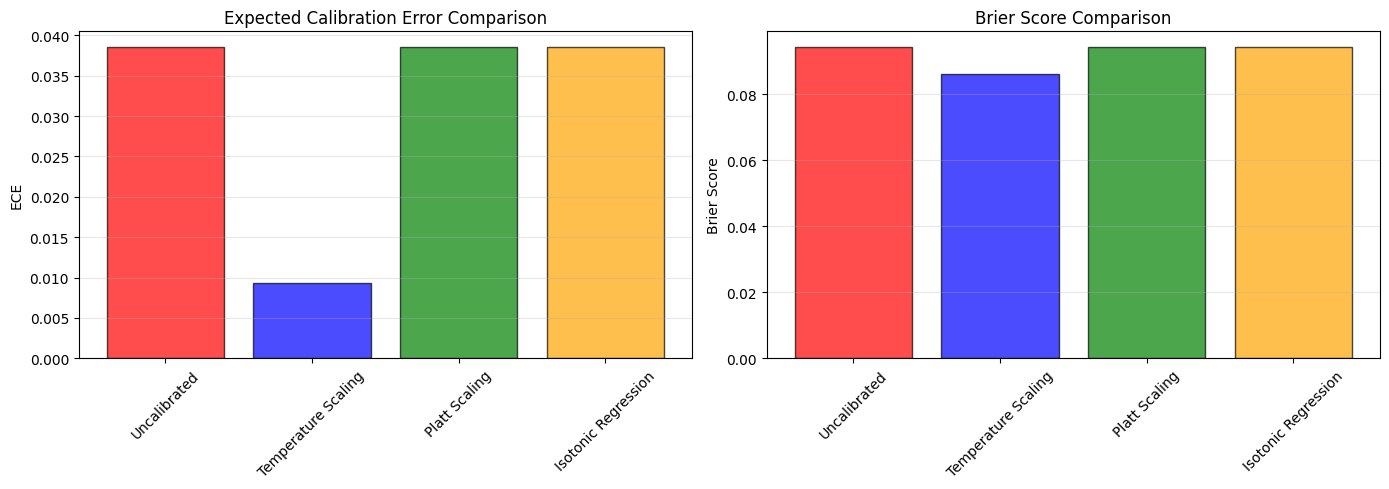

In [ ]:
print('='*60)
print('COMPREHENSIVE MODEL COMPARISON (INCLUDING BAYESIAN)')
print('='*60)

print('\nLoading Bayesian results for comparison...')
try:
    bayesian_results = np.load('./data/results/bayesian_posterior.npy', allow_pickle=True).item()
    metric_results = np.load('./data/results/metric_uncertainty_results.npy', allow_pickle=True).item()
    
    bayesian_mean = bayesian_results['mean']
    ece_hdi = metric_results['ece_hdi']
    
    print(f'\n{"Method":<30} {"Accuracy":<12} {"ECE":<18} {"Brier":<18} {"Uncertainty":<25}')
    print('-'*103)
    print(f'{"Uncalibrated":<30} {acc_uncal:<12.4f} {ece_uncal:<18.4f} {brier_uncal:<18.4f} {"N/A":<25}')
    print(f'{"L-BFGS":<30} {acc_temp:<12.4f} {ece_temp:<18.4f} {brier_temp:<18.4f} {"N/A":<25}')
    print(f'{"Bayesian (mean)":<30} {acc_temp:<12.4f} {metric_results["ece_mean"]:<18.4f} {metric_results["brier_mean"]:<18.4f} {f"ECE: [{ece_hdi[0]:.4f}, {ece_hdi[1]:.4f}]":<25}')
    print(f'{"Platt Scaling":<30} {acc_platt:<12.4f} {ece_platt:<18.4f} {brier_platt:<18.4f} {"N/A":<25}')
    print(f'{"Isotonic Regression":<30} {acc_iso:<12.4f} {ece_iso:<18.4f} {brier_iso:<18.4f} {"N/A":<25}')
    
    print('\nKey Advantages of Bayesian Approach:')
    print(f'  1. Provides uncertainty quantification: Temperature HDI [{bayesian_results["hdi_lower"]:.4f}, {bayesian_results["hdi_upper"]:.4f}]')
    print(f'  2. Quantifies uncertainty in calibration metrics: ECE HDI [{ece_hdi[0]:.4f}, {ece_hdi[1]:.4f}]')
    print('  3. Enables risk assessment and better decision-making')
    print('  4. Critical when validation data is limited')
except FileNotFoundError:
    print('Bayesian results not found. Run Notebook 3 first.')

COMPREHENSIVE MODEL COMPARISON (INCLUDING BAYESIAN)

Loading Bayesian results for comparison...

Method                         Accuracy     ECE             Brier           Uncertainty              
-------------------------------------------------------------------------------------------------
Uncalibrated                   0.9440       0.0386          0.0943          N/A                      
L-BFGS                         0.9440       0.0094          0.0860          N/A                      
Bayesian (mean)                0.9440       0.0091          0.0860          ECE: [0.0061, 0.0134]    
Platt Scaling                  0.9440       0.0386          0.0943          N/A                      
Isotonic Regression            0.9440       0.0386          0.0943          N/A                      

Key Advantages of Bayesian Approach:
  1. Provides uncertainty quantification: Temperature HDI [0.0991, 0.1034]
  2. Quantifies uncertainty in calibration metrics: ECE HDI [0.0061, 0.0134]
  3

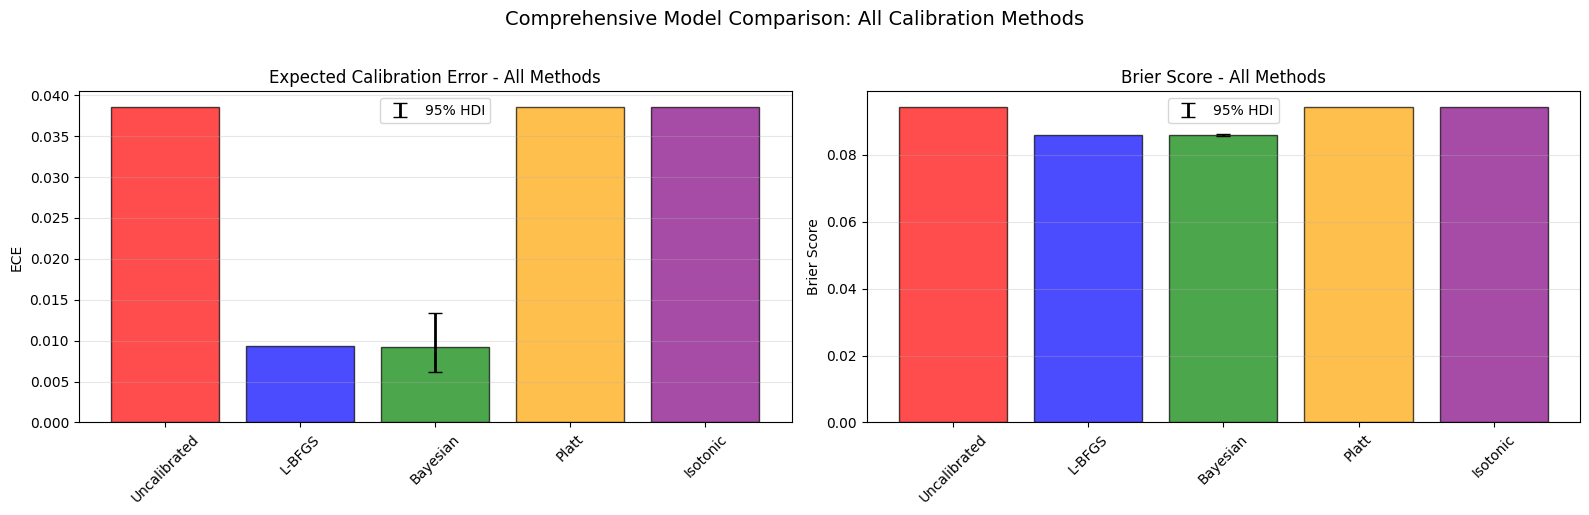


Visualization shows:
- Bayesian method includes uncertainty intervals (error bars)
- Lower bars indicate better calibration
- Bayesian provides additional information: uncertainty quantification


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['Uncalibrated', 'L-BFGS', 'Bayesian', 'Platt', 'Isotonic']
ece_scores = [ece_uncal, ece_temp, metric_results.get('ece_mean', ece_temp), ece_platt, ece_iso]
brier_scores = [brier_uncal, brier_temp, metric_results.get('brier_mean', brier_temp), brier_platt, brier_iso]

if 'ece_std' in metric_results:
    ece_err = [0, 0, metric_results['ece_std'], 0, 0]
    axes[0].errorbar(range(len(methods)), ece_scores, yerr=ece_err, fmt='o-', capsize=5, linewidth=2, markersize=8)
else:
    axes[0].plot(range(len(methods)), ece_scores, 'o-', linewidth=2, markersize=8)

axes[0].set_xticks(range(len(methods)))
axes[0].set_xticklabels(methods, rotation=45, ha='right')
axes[0].set_ylabel('ECE')
axes[0].set_title('Expected Calibration Error Comparison')
axes[0].grid(True, alpha=0.3)

if 'brier_std' in metric_results:
    brier_err = [0, 0, metric_results['brier_std'], 0, 0]
    axes[1].errorbar(range(len(methods)), brier_scores, yerr=brier_err, fmt='s-', capsize=5, linewidth=2, markersize=8)
else:
    axes[1].plot(range(len(methods)), brier_scores, 's-', linewidth=2, markersize=8)

axes[1].set_xticks(range(len(methods)))
axes[1].set_xticklabels(methods, rotation=45, ha='right')
axes[1].set_ylabel('Brier Score')
axes[1].set_title('Brier Score Comparison')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\nVisualization shows:')
print('- Bayesian method includes uncertainty intervals (error bars)')
print('- Lower bars indicate better calibration')
print('- Bayesian provides additional information: uncertainty quantification')

In [ ]:
print('='*60)
print('SAVING BASELINE RESULTS')
print('='*60)

os.makedirs('./data/results', exist_ok=True)

baseline_results = {
    'calibrated_temp': calibrated_temp,
    'results': results
}

np.save('./data/results/baseline_results.npy', baseline_results, allow_pickle=True)

print('✓ Baseline results saved to ./data/results/baseline_results.npy')
print(f'\nKey baseline value:')
print(f'  L-BFGS Temperature: {calibrated_temp:.4f}')
print('  This will be used as prior center for Bayesian methods')
print('\nNext step: Run Notebook 3 for Bayesian temperature scaling')

SAVING BASELINE RESULTS
✓ Baseline results saved to ./data/results/baseline_results.npy

Key baseline value:
  L-BFGS Temperature: 1.7258
  This will be used as prior center for Bayesian methods

Next step: Run Notebook 3 for Bayesian temperature scaling
